In [274]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(purrr)
library(xtable)

### Question 7.3

blue crabs

In [275]:
blue <- read.table(
  "http://www2.stat.duke.edu/~pdh10/FCBS/Exercises/bluecrab.dat",
  header = TRUE
)
colnames(blue) <- c("Y1", "Y2")

Y <- as.matrix(blue)
n <- nrow(Y)
p <- ncol(Y)          # should be 2
ybar <- colMeans(Y)

## ---------- Prior hyperparameters ----------
mu_0   <- ybar               # sample mean
Lambda0 <- cov(Y)            # sample covariance
S0      <- cov(Y)            # sample covariance
nu_0    <- 4

Lambda0_inv <- solve(Lambda0)

In [276]:


# one draw from N(mu, Sigma)
rmvnorm_1 <- function(mu, Sigma) {
  mu <- as.vector(mu)
  p <- length(mu)
  z <- rnorm(p)
  L <- chol(Sigma)          # t(L) %*% L = Sigma
  as.vector(mu + t(L) %*% z)
}

# one draw from Inv-Wishart(df, S)
rInvWishart_1 <- function(df, S) {
  # Sigma^{-1} ~ Wishart(df, S^{-1})
  W <- rWishart(1, df = df, Sigma = solve(S))[,,1]
  solve(W)
}


In [277]:
## ---------- Gibbs sampler ----------
n_iter <- 10000

theta_draws_blue <- matrix(NA, n_iter, p)        # each row: theta^(t)
Sigma_draws_blue <- array(NA, dim = c(p, p, n_iter))  # each slice: Sigma^(t)

# initial values
theta_cur <- mu_0
Sigma_cur <- S0

for (t in 1:n_iter) {
  ## 1. Sample Sigma | theta, Y
  resid <- sweep(Y, 2, theta_cur, "-")      # Y_i - theta
  S_n   <- S0 + t(resid) %*% resid
  nu_n  <- nu_0 + n
  Sigma_cur <- rInvWishart_1(df = nu_n, S = S_n)

  ## 2. Sample theta | Sigma, Y
  Sigma_inv    <- solve(Sigma_cur)
  Lambda_n_inv <- Lambda0_inv + n * Sigma_inv
  Lambda_n     <- solve(Lambda_n_inv)
  mu_n         <- Lambda_n %*% (Lambda0_inv %*% mu_0 + n * Sigma_inv %*% ybar)

  theta_cur <- rmvnorm_1(mu = mu_n, Sigma = Lambda_n)

  ## store draws
  theta_draws_blue[t, ]    <- theta_cur
  Sigma_draws_blue[,, t]   <- Sigma_cur
}

dim(theta_draws_blue)   # 10000 x 2
dim(Sigma_draws_blue)   # 2 x 2 x 10000

[1] 10000     2

[1]     2     2 10000

orange crabs

In [278]:
mu_orange = colMeans(orange)
e_cov_orange = cov(orange)

Lambda0_orange <- e_cov_orange
S0_orange      <- e_cov_orange

Lambda0_inv_orange <- solve(Lambda0_orange)

nu0 <- 4

In [279]:

orange <- read.table(
  "http://www2.stat.duke.edu/~pdh10/FCBS/Exercises/orangecrab.dat",
  header = TRUE
)
colnames(orange) <- c("Y1", "Y2")

Y <- as.matrix(orange)
n <- nrow(Y)
p <- ncol(Y)          # should be 2
ybar <- colMeans(Y)

## ---------- Prior hyperparameters ----------
mu_0   <- ybar               # sample mean
Lambda0 <- cov(Y)            # sample covariance
S0      <- cov(Y)            # sample covariance
nu_0    <- 4

Lambda0_inv <- solve(Lambda0)

In [280]:


## ---------- Gibbs sampler ----------
n_iter <- 10000

theta_draws_orange <- matrix(NA, n_iter, p)        # each row: theta^(t)
Sigma_draws_orange <- array(NA, dim = c(p, p, n_iter))  # each slice: Sigma^(t)

# initial values
theta_cur <- mu_0
Sigma_cur <- S0

for (t in 1:n_iter) {
  ## 1. Sample Sigma | theta, Y
  resid <- sweep(Y, 2, theta_cur, "-")      # Y_i - theta
  S_n   <- S0 + t(resid) %*% resid
  nu_n  <- nu_0 + n
  Sigma_cur <- rInvWishart_1(df = nu_n, S = S_n)

  ## 2. Sample theta | Sigma, Y
  Sigma_inv    <- solve(Sigma_cur)
  Lambda_n_inv <- Lambda0_inv + n * Sigma_inv
  Lambda_n     <- solve(Lambda_n_inv)
  mu_n         <- Lambda_n %*% (Lambda0_inv %*% mu_0 + n * Sigma_inv %*% ybar)

  theta_cur <- rmvnorm_1(mu = mu_n, Sigma = Lambda_n)

  ## store draws
  theta_draws_orange[t, ]    <- theta_cur
  Sigma_draws_orange[,, t]   <- Sigma_cur
}

dim(theta_draws_orange)   # 10000 x 2
dim(Sigma_draws_orange)   # 2 x 2 x 10000


[1] 10000     2

[1]     2     2 10000

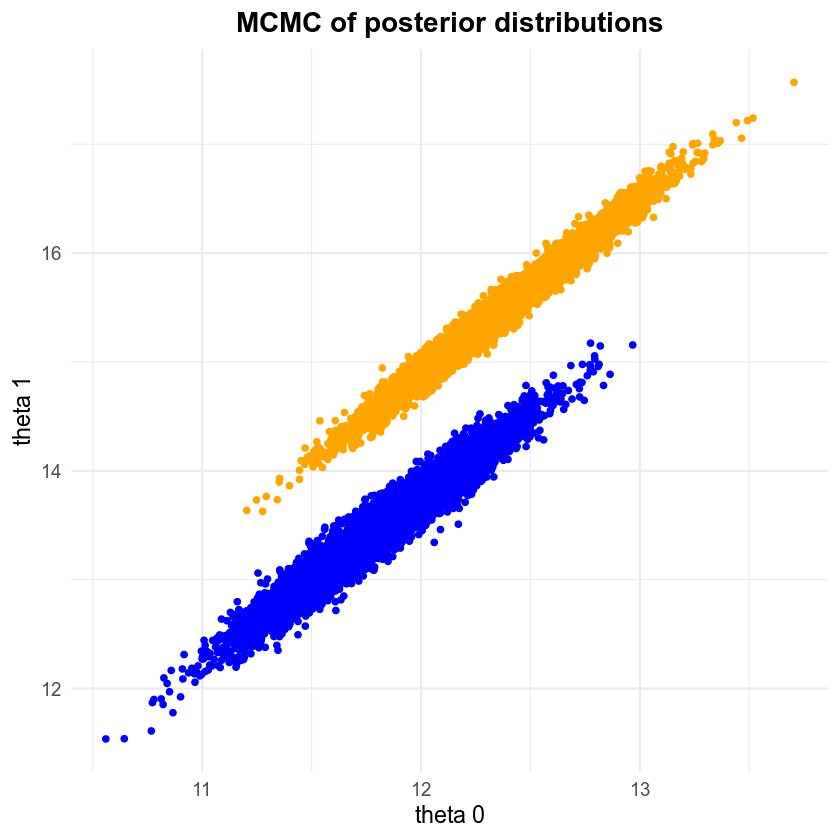

In [281]:
p <- ggplot() +
    geom_point(aes(x=theta_draws_blue[, 1], y=theta_draws_blue[, 2]), color='blue') + 
    geom_point(aes(x=theta_draws_orange[, 1], y=theta_draws_orange[, 2]), color = 'orange') +
labs(title = 'MCMC of posterior distributions', x='theta 0', y= 'theta 1') +
theme_minimal(base_size = 14) +
  theme(
    legend.position = "top",
    plot.title = element_text(hjust = 0.5, face = "bold")
  )


p
ggsave("../Figures/Assignment_4/7.2.png", plot = p, width = 7, height = 5, dpi = 300, bg = "white")

In [282]:
n_iter <- dim(Sigma_draws_blue)[3]

rho_blue <- numeric(n_iter)
rho_orange <- numeric(n_iter)

for (t in 1:n_iter) {
  S_b <- Sigma_draws_blue[,, t]
  rho_blue[t] <- S_b[1, 2] / sqrt(S_b[1, 1] * S_b[2, 2])

  S_o <- Sigma_draws_orange[,, t]
  rho_orange[t] <- S_o[1, 2] / sqrt(S_o[1, 1] * S_o[2, 2])
}


In [283]:
df_rho <- data.frame(
  rho   = c(rho_blue, rho_orange),
  group = factor(rep(c("Blue", "Orange"),
                     each = length(rho_blue)))
)

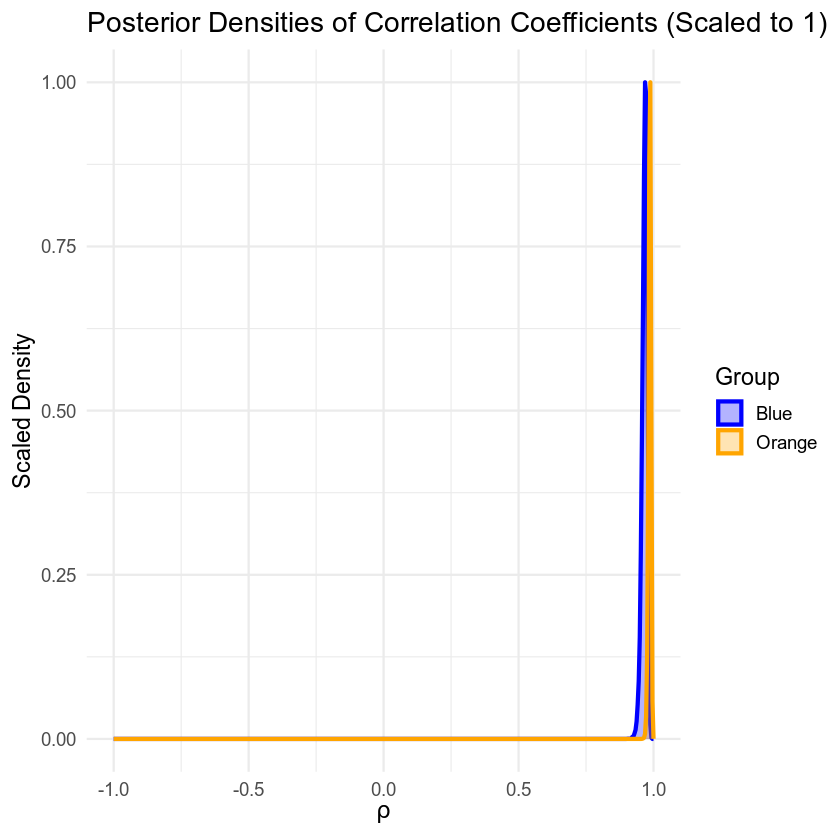

In [296]:
p <- ggplot(df_rho, aes(x = rho, fill = group, color = group)) +
  geom_density(aes(y = after_stat(scaled)),   #
               alpha = 0.3, linewidth = 1.2) +
  scale_color_manual(values = c("blue", "orange")) +
  scale_fill_manual(values = c("blue", "orange")) +
  xlim(-1, 1) +
  labs(
    title = "Posterior Densities of Correlation Coefficients (Scaled to 1)",
    x = expression(rho),
    y = "Scaled Density",
    fill = "Group",
    color = "Group"
  ) +
  theme_minimal(base_size = 14)

ggsave("../Figures/Assignment_4/7.2_density.png", plot = p, width = 7, height = 5, dpi = 300, bg = "white")
p

In [285]:
prob_blue_less <- mean(rho_blue < rho_orange)
prob_blue_less

[1] 0.984

In [286]:
mean(rho_blue);  quantile(rho_blue,  c(0.025, 0.975))
mean(rho_orange);quantile(rho_orange, c(0.025, 0.975))

[1] 0.9669683

2.5%     97.5% 
0.9454119 0.9816124

[1] 0.9860466

2.5%     97.5% 
0.9768496 0.9922832

### Question 7.4

In [287]:
age <- read.table("http://www2.stat.duke.edu/~pdh10/FCBS/Exercises/agehw.dat",
                  header = TRUE)
colnames(age) <- c("husband", "wife")
Y <- as.matrix(age)
n <- nrow(Y)
p <- ncol(Y)
ybar <- colMeans(Y)


In [288]:
mu0 <- c(40, 36)                 # prior mean ages (husband, wife)
Lambda0 <- diag(c(10^2, 10^2))   # prior covariance for theta

# prior scale matrix for Sigma: SD ~ 5 years, corr ~ 0.8
sd_h <- 10
sd_w <- 19
rho  <- 0.8
S0 <- matrix(c(sd_h^2, rho*sd_h*sd_w,
               rho*sd_h*sd_w, sd_w^2), nrow = 2, byrow = TRUE)

nu0 <- 4                          # prior df for Sigma

n  <- 1000                         # size of prior predictive dataset
n_sets <- 3                       # how many datasets to simulate

In [289]:
all_data <- list()

for (k in 1:n_sets) {

  # sample (theta, Sigma)
  theta <- rmvnorm_1(mu0, Lambda0)
  Sigma <- rInvWishart_1(nu0, S0)

  # sample Y_1,...,Y_n
  Y <- t(replicate(n, rmvnorm_1(theta, Sigma)))
  df <- data.frame(
    husband = Y[,1],
    wife = Y[,2],
    dataset = factor(k)
  )

  all_data[[k]] <- df
}

prior_df <- none
prior_df <- do.call(rbind, all_data)

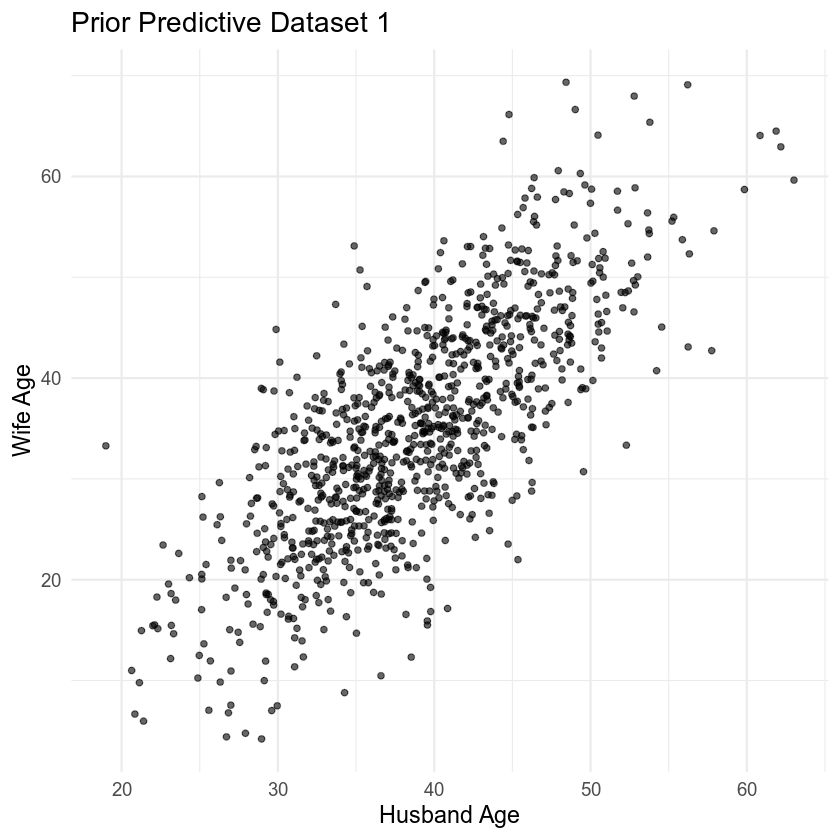

In [290]:
p <- ggplot(subset(prior_df, dataset==1), aes(husband, wife)) +
    geom_point( alpha = 0.6) +
    labs(
      title = paste("Prior Predictive Dataset", 1),
      x = "Husband Age",
      y = "Wife Age"
    ) +
    theme_minimal(base_size = 14)

  ggsave("../Figures/Assignment_4/7.3_1.png", plot = p, width = 7, height = 5, dpi = 300, bg = "white")
  print(p)   

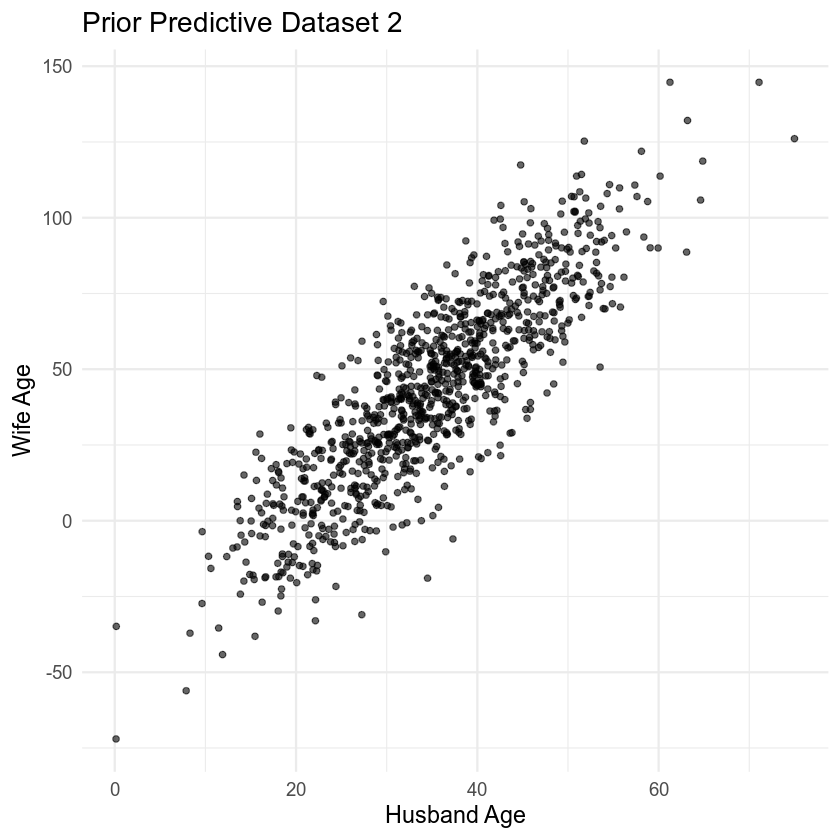

In [291]:
p <- ggplot(subset(prior_df, dataset==2), aes(husband, wife)) +
    geom_point(alpha = 0.6) +
    labs(
      title = paste("Prior Predictive Dataset", 2),
      x = "Husband Age",
      y = "Wife Age"
    ) +
    theme_minimal(base_size = 14)

  ggsave("../Figures/Assignment_4/7.3_2.png", plot = p, width = 7, height = 5, dpi = 300, bg = "white")
  print(p)   

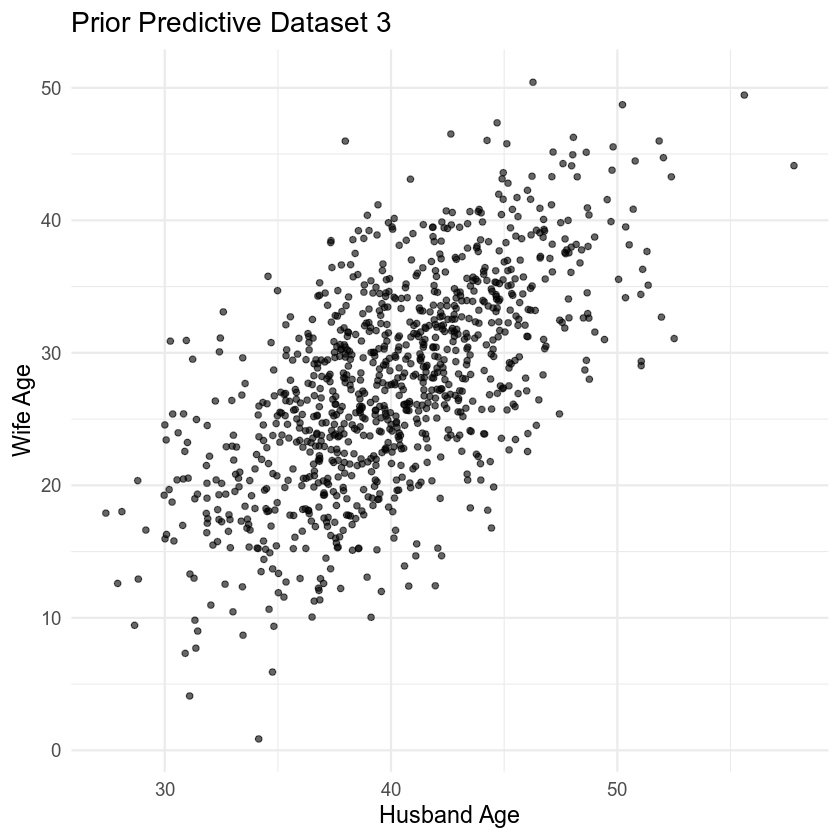

In [292]:
p <- ggplot(subset(prior_df, dataset==3), aes(husband, wife)) +
    geom_point( alpha = 0.6) +
    labs(
      title = paste("Prior Predictive Dataset", 3),
      x = "Husband Age",
      y = "Wife Age"
    ) +
    theme_minimal(base_size = 14)

  ggsave("../Figures/Assignment_4/7.3_3.png", plot = p, width = 7, height = 5, dpi = 300, bg = "white")
  print(p)   

In [293]:
ggplot(age, aes(x = ageh, y=agew)) +
    geom_point()

ERROR while rich displaying an object: Error in `geom_point()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error in `FUN()`:
! object 'ageh' not found

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(

In [294]:
n_iter <- 12000
burn   <- 2000
theta_draws <- matrix(NA, n_iter, p)
Sigma_draws <- array(NA, dim = c(p, p, n_iter))

theta_cur <- mu0
Sigma_cur <- S0

for (t in 1:n_iter) {
  ## Sample Sigma | theta, Y
  resid <- sweep(Y, 2, theta_cur, "-")
  S_n   <- S0 + t(resid) %*% resid
  nu_n  <- nu0 + n
  Sigma_cur <- rInvWishart_1(nu_n, S_n)

  ## Sample theta | Sigma, Y
  Sigma_inv    <- solve(Sigma_cur)
  Lambda_n_inv <- Lambda0_inv + n * Sigma_inv
  Lambda_n     <- solve(Lambda_n_inv)
  mu_n         <- Lambda_n %*% (Lambda0_inv %*% mu0 + n * Sigma_inv %*% ybar)

  theta_cur <- rmvnorm_1(mu_n, Lambda_n)

  theta_draws[t, ]  <- theta_cur
  Sigma_draws[,, t] <- Sigma_cur
}

keep <- (burn + 1):n_iter
theta_post <- theta_draws[keep, ]
Sigma_post <- Sigma_draws[,, keep]

ERROR: Error in matrix(NA, n_iter, p): non-numeric matrix extent


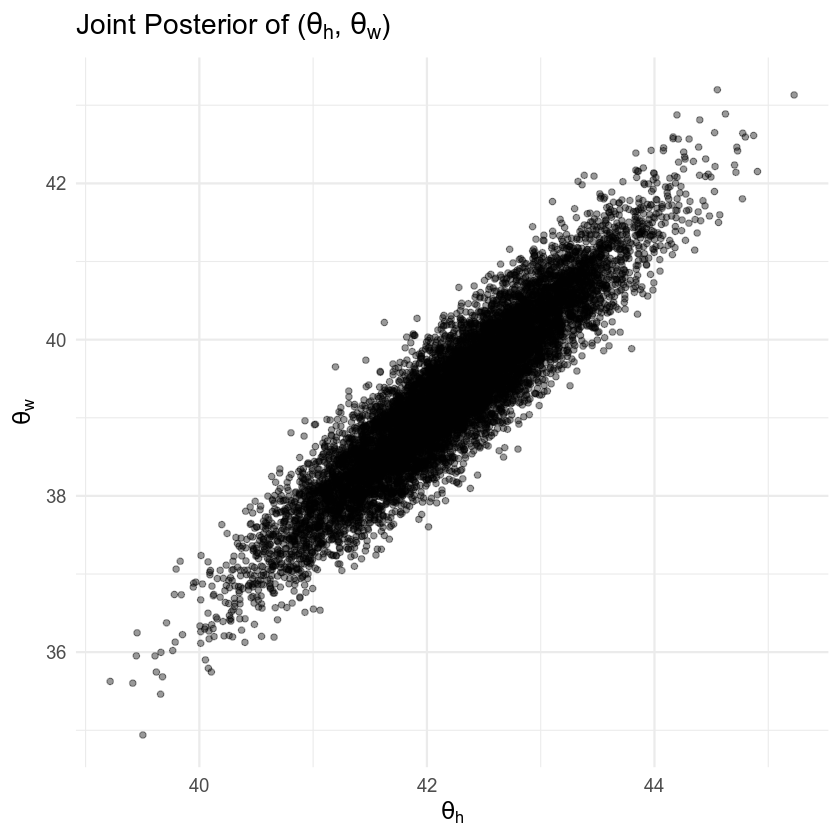

In [ ]:
df_theta <- data.frame(
  theta_h = theta_post[,1],
  theta_w = theta_post[,2]
)

p <-ggplot(df_theta, aes(theta_h, theta_w)) +
  geom_point(alpha = 0.4) +
  labs(
    title = expression(paste("Joint Posterior of (", theta[h], ", ", theta[w], ")")),
    x = expression(theta[h]),
    y = expression(theta[w])
  ) +
  theme_minimal(base_size = 14)

ggsave("../Figures/Assignment_4/7.4_c1.png", plot = p, width = 7, height = 5, dpi = 300, bg = "white")
print(p)   

In [ ]:
colMeans(df_theta)

theta_h  theta_w 
42.22847 39.29894

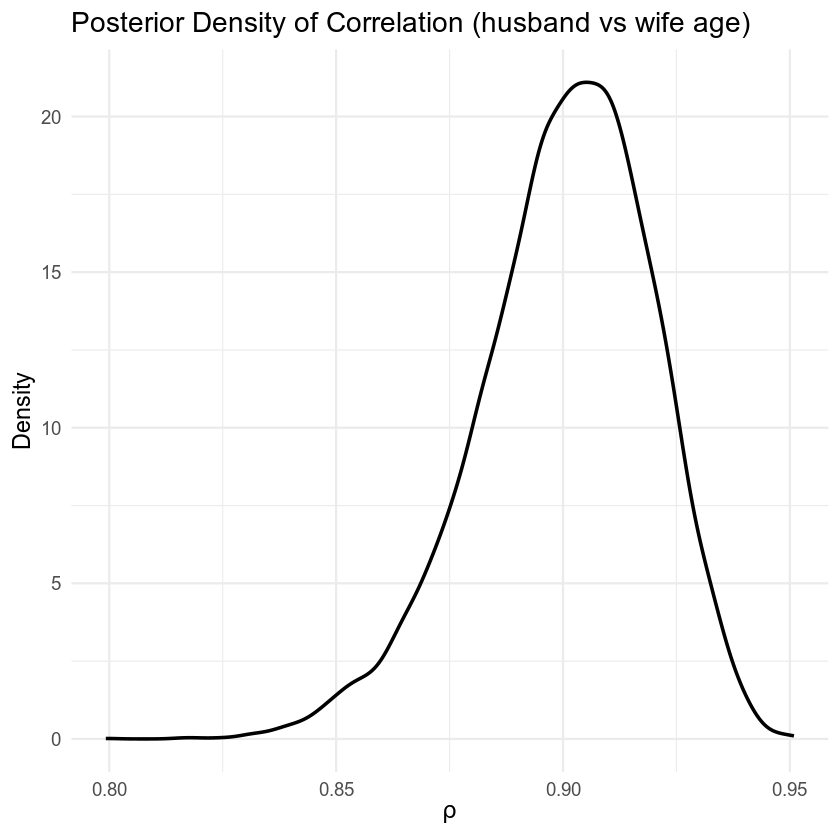

In [ ]:


## 5. Posterior correlation draws
rho_post <- sapply(1:length(keep), function(i) {
  S <- Sigma_post[,, i]
  S[1, 2] / sqrt(S[1, 1] * S[2, 2])
})


## 7. Marginal posterior density of correlation
df_rho <- data.frame(rho = rho_post)

p <- ggplot(df_rho, aes(rho)) +
  geom_density(linewidth = 1) +
  labs(
    title = "Posterior Density of Correlation (husband vs wife age)",
    x = expression(rho),
    y = "Density"
  ) +
  theme_minimal(base_size = 14)

ggsave("../Figures/Assignment_4/7.4_c2.png", plot = p, width = 7, height = 5, dpi = 300, bg = "white")
print(p)   

In [ ]:
theta_CI <- apply(theta_post, 2, quantile, probs = c(0.025, 0.975))
rho_CI   <- quantile(rho_post, probs = c(0.025, 0.975))

theta_CI   # 95% CI for theta_h, theta_w

2.5%,40.67591,37.23700
97.5%,43.72264,41.33423


In [ ]:
rho_CI     # 95% CI for correlation

2.5%     97.5% 
0.8573166 0.9327719